# Data

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame( columns = ['cat_1', 'cat_2'] )

n = 4
m = 5

sample_size = 100

df['cat_1'] = np.random.randint(1, n, sample_size)
df['cat_2'] = np.random.randint(1, m, sample_size)
df['random_x'] = np.random.random(sample_size)

beta = np.random.rand()

shift_cat1 = np.random.rand(df['cat_1'].nunique())
shift_cat2 = np.random.rand(df['cat_2'].nunique())

df['random_y'] = beta* df['random_x'] + np.random.rand(sample_size)
df['random_y'] = df['random_y'] + shift_cat1[df['cat_1'].values - 1] + shift_cat2[df['cat_2'].values - 1]

# Data Visualization

In the presence of noise, lets visualization the data.

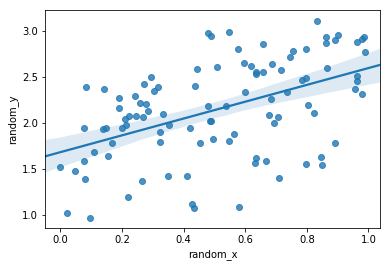

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot( x = df['random_x'], y = df['random_y'])
plt.show()

This data is very noisy.  We may not get good results at all due to the noise.  Lets see how the Bayesian model handles the noise.

# Modelling

Fitting our model to the data will take a while, please be patient.

In [4]:
from bayes_tree import BGRFRegressor

model = BGRFRegressor(['random_x', 'cat_1', 'cat_2'], 'random_y', n_estimators = 100, max_depth = 3)

In [5]:
model.fit(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_231d62c391ab0568e3f1d2d998baf749 NOW.
/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [6]:
print(model.model)

Inference for Stan model: anon_model_231d62c391ab0568e3f1d2d998baf749.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]    0.01  2.4e-4   0.02  -0.02 8.6e-3   0.01   0.02   0.05   4000    1.0
beta[1]    0.01  2.3e-4   0.01  -0.02 8.1e-3   0.01   0.02   0.04   4000    1.0
beta[2]    0.01  2.5e-4   0.02  -0.02 7.9e-3   0.01   0.02   0.04   4000    1.0
beta[3]    0.01  2.4e-4   0.01  -0.02 8.5e-3   0.01   0.02   0.05   4000    1.0
beta[4]    0.01  2.5e-4   0.02  -0.02 8.7e-3   0.01   0.02   0.04   4000    1.0
beta[5]    0.01  2.2e-4   0.01  -0.01 8.8e-3   0.01   0.02   0.04   4000    1.0
beta[6]    0.01  2.3e-4   0.01  -0.02 8.6e-3   0.01   0.02   0.05   4000    1.0
beta[7]    0.01  2.4e-4   0.02  -0.01 9.3e-3   0.01   0.02   0.05   4000   1.01
beta[8]    0.01  2.2e-4   0.01  -0.02 8.1e-3   0.01   0.02   0.04   4000    1.0
beta[9]    

# Validation Performance

In [7]:
df_val = pd.DataFrame( columns = ['random_x'])

df_val['random_x'] = np.random.rand(100)

df_val['cat_1'] = np.random.randint(1, n, 100)
df_val['cat_2'] = np.random.randint(1, m, 100)

y_val = beta*df_val['random_x'].values + shift_cat1[df_val['cat_1'].values - 1] + shift_cat2[df_val['cat_2'].values - 1]

Lets visualization the data before we test our metrics

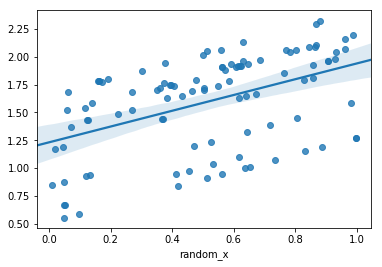

In [8]:
sns.regplot( x = df_val['random_x'], y = y_val )
plt.show()

In [9]:
r2_score_train = model.score(df, df['random_y'])
r2_score_val = model.score(df_val, y_val)

print('The train R^2 score is: ' + str( round(r2_score_train, 4)))
print('The validation R^2 score is: ' + str( round(r2_score_val, 4)))

The train R^2 score is: 0.7795
The validation R^2 score is: -0.8859


As we can see, the R^2 score is really good.  However, before we write this off, lets compare to Random Forest with each decision tree having uniform weight.

# Prediction Visualization

In [10]:
y_val_pred = model.predict(df_val)

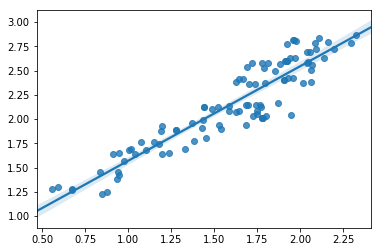

In [11]:
sns.regplot( x = y_val, y = y_val_pred )

plt.show()

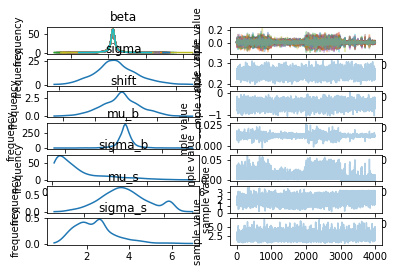

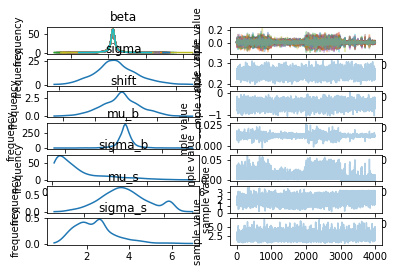

In [12]:
model.model.plot()

# Non-Bayesian Performance


In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor( n_estimators = 100, max_depth = 3, n_jobs = -1 )

rf_reg.fit( df[['random_x', 'cat_1', 'cat_2']], df['random_y'] )

r2_score_train = rf_reg.score( df[['random_x', 'cat_1', 'cat_2']], df['random_y'] )
r2_score_val = rf_reg.score( df_val[['random_x', 'cat_1', 'cat_2']], y_val )

print('The train R^2 score is: ' + str( round(r2_score_train, 4)))
print('The validation R^2 score is: ' + str( round(r2_score_val, 4)))

The train R^2 score is: 0.7475
The validation R^2 score is: -0.928


# Comments

This shows that, with the presence of white noise, the Bayesian model is more equipped to learn from noisy data and make better predictions, while also taking care of the categorial differences in the data. The Random Forest regression model does a poorer job than the Bayesian model.